<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

array([ 1,  2,  3, ..., 22, 23, 24])

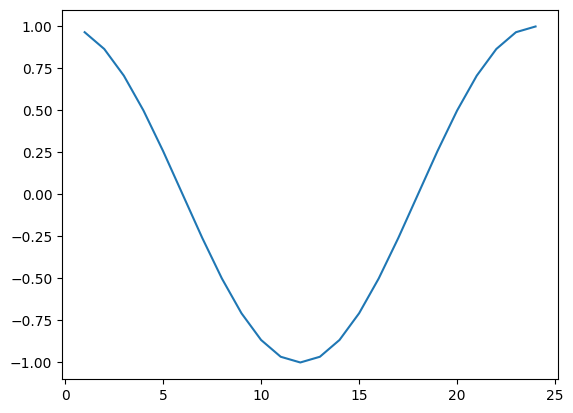

In [16]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1.0,25.0,1)
y = np.cos(np.pi * x / 12)

plt.plot(x,y)
plt.show()

# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in PyTorch**  

* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning, PyTorch [[Video]](https://www.youtube.com/watch?v=CZi5Avp6p1s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* Part 10.2: LSTM-Based Time Series with PyTorch [[Video]](https://www.youtube.com/watch?v=hIQLy5zCgH4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* **Part 10.3: Transformer-Based Time Series with PyTorch** [[Video]](https://www.youtube.com/watch?v=NGzQpphf_Vc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_3_transformer_timeseries.ipynb)
* Part 10.4: Seasonality and Trend [[Video]](https://www.youtube.com/watch?v=HOkxoLaUF9s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_4_seasonal.ipynb)
* Part 10.5: Predicting with Meta Prophet [[Video]](https://www.youtube.com/watch?v=MzjMVsz0GyA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_5_prophet.ipynb)

# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [11]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


# Part 10.5: Transformers for TimeSeries in PyTorch

The transformative landscape of deep learning has witnessed monumental strides in the recent past, particularly in the domain of Natural Language Processing (NLP). Central to this revolution has been the advent of transformer architectures, which, with their attention mechanisms, have pushed the boundaries of what's achievable in tasks like machine translation, sentiment analysis, and language modeling. However, while transformers initially rose to prominence primarily within the realm of NLP, their applicability isn't restricted to just textual data. A growing wave of interest has emerged around leveraging these models for time-series predictions—a challenge that, though numerically distinct, bears conceptual resemblance to understanding sequences in language.

In time-series prediction, the objective often centers around forecasting future values based on historical data. This could involve predicting stock prices, weather patterns, or even the consumption of electricity in a region. At its core, this is a sequence-to-sequence task, where the past values form an input sequence and the future values to be predicted form an output sequence. Now, consider the similarities with machine translation in NLP, where an input sequence (sentence) in one language is translated into an output sequence in another language. Both scenarios require the model to recognize patterns, interdependencies, and context across sequences.

This chapter delves deep into the nuances of using PyTorch transformers for time-series prediction. We will embark on this journey by first establishing a foundational understanding of how transformers operate within the NLP space, before segueing into their adaptation for numeric sequences. By juxtaposing these two applications, readers will gain a comprehensive appreciation of the transformer's versatility and the subtle considerations required when transitioning from text to time.



## Loading Sun Spot Data for a Transformer Time Series

We will look at the same sunspot data as the previous section. However, this time we will use a transformer to predict. You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

We use the following code to load the sunspot file:


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

The data preprocessing is the same as was introduced in the previous section. We will use data before the year 2000 as training, the rest is used for validation.

In [2]:
# Data Preprocessing
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()



Just like we did for LSTM in the previous section, we again break the data into sequences.

In [5]:
len(spots_train)

55160

In [3]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)] 
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [8]:
x_train.size() , y_train.size()

(torch.Size([55150, 10, 1]), torch.Size([55150, 1]))

# Position Encoding for Transformers

In the realm of the transformer architecture, a pivotal component that ensures the model's success is its ability to consider the sequence's order. Unlike traditional RNNs or LSTMs, which process sequences step-by-step and inherently respect their order, transformers process all tokens in a sequence simultaneously. While this parallel processing significantly boosts computational efficiency and allows for long-range dependencies to be captured more effectively, it also means that transformers, in their native form, are oblivious to the position or order of tokens in a sequence. This is where the concept of positional encoding comes into play.

Positional encoding is a mechanism to provide the transformer with information about the position of tokens within a sequence. Essentially, it infuses order information into the otherwise position-agnostic embeddings. By adding positional encodings to the token embeddings before feeding them into the transformer, each token's position in the sequence becomes discernible to the model.

Positional encodings are vectors that get added to the embeddings of tokens. The intuition is to design these vectors in such a way that their values or patterns are unique for each position, allowing the model to differentiate between different positions in the sequence.

A popular method to generate positional encodings is using sinusoidal functions. For a given position $p$ in the sequence and dimension $d$ of the embedding, the positional encoding is computed as:

$$ PE(2,i) = \sin(\frac{p}{10000^{2i/d}}) $$
$$ PE(2,i+1) = \cos(\frac{p}{10000^{2i/d}}) $$

Where $i$ is the dimension index. These sinusoidal functions generate values between -1 and 1 and ensure a unique and repeatable pattern for each position.

The choice of sinusoidal functions isn't arbitrary. They have two compelling properties:

1. They produce values between -1 and 1, making them compatible with most embedding value ranges.
2. Their patterns allow the model to extrapolate positions beyond the sequence lengths seen during training.

One might wonder, why not just append or add the token's position as an integer to the embedding? The challenge with this approach is scale. Embedding values, especially after being trained, can exist within a specific range, and directly adding large integers (for tokens further down in long sequences) might disrupt the information in the original embeddings.

Furthermore, using raw integers wouldn't provide a consistent way for the model to generalize or extrapolate to sequence lengths not seen during training. Sinusoidal functions, in contrast, offer a predictable pattern that aids in such extrapolation.

The following code describes a simple implementation of a transformer-based model using PyTorch's built-in functionalities. The **TransformerModel** class encapsulates a transformer-based neural network designed for sequence processing. Upon initialization, the model sets up several components: an encoder to adjust the input data to a desired dimension, a **pos_encoder** to bestow the sequence with positional information, a core **transformer_encoder** comprising several layers to process the sequence, and a **decoder** to produce the final output. As data flows through the model during the forward pass, it undergoes a series of transformations: it's first projected to a higher dimension, then augmented with positional encodings, processed by the transformer layers, and finally, the last token's representation is harnessed to produce the output. An instance of this model is readily created and can be assigned to a computation device for further training or inference.



In [9]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Constructing the Transformer Model

The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

* **input_dim**: The dimension of the input data, in this case we use only one input, the number of sunspots.
* **d_model**: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
* **nhead**: The number of attention heads in the multi-head self-attention mechanism.
* **num_layers**: The number of transformer encoder layers.
dropout: The dropout probability.



In [12]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

The Transformer architecture in PyTorch is governed by crucial configuration choices, among which **d_model**, **nhead**, and **num_layers** hold significant weight. The **d_model** denotes the dimensionality of the input embeddings and affects the model's capacity to learn intricate representations. While a more substantial **d_model** can bolster the richness of the model's understanding, it also amplifies the computational demand and can pose overfitting risks if not carefully chosen. Parallelly, the model's gradient flow and initialization are impacted by this choice, though the Transformer's normalization layers often moderate potential issues.

On the other hand, **nhead** reflects the count of heads in the multi-head attention mechanism. A higher number of heads grants the model the prowess to simultaneously focus on diverse segments of the input, enabling the capture of varied contextual nuances. However, there's a trade-off. Beyond a specific threshold, the computational overhead might outweigh the marginal performance gains. This parallel processing, provided by multiple attention heads, tends to offer more stable and varied gradient information, positively influencing the training dynamics.

Lastly, the **num_layers** parameter dictates the depth of the Transformer, determining the number of stacked encoder or decoder layers. A deeper model, as a result of increased layers, can discern more complex and hierarchical relationships in data. Still, there's a caveat: after a certain depth, potential performance enhancements may plateau, and the risk of overfitting might escalate. Training deeper models also comes with its set of challenges. Although residual connections and normalization in Transformers alleviate some concerns, a high layer count might necessitate techniques like gradient clipping or learning rate adjustments for stable training.

In essence, these parameters intricately balance model capacity, computational efficiency, and generalization capability. Their optimal settings often emerge from task-specific experimentation, the nature of the data, and available computational prowess.

## Training the Model


Training a transformer-based model adheres to many of the familiar paradigms and best practices that apply to other neural network architectures. Much like the models we've encountered before, a transformer-based model benefits from training in batches, which helps in both computational efficiency and generalization. Batched training ensures that the model updates its weights based on the average gradient over several data points, rather than being excessively influenced by any single instance. Additionally, the use of early stopping acts as a safeguard against overfitting. By monitoring the model's performance on a validation set and halting training when no significant improvement is observed over a set number of epochs, we ensure that the model generalizes well and doesn't just memorize the training data. The validation set, it remains an essential component in the training regimen, providing a proxy measure of the model's performance on unseen data and guiding hyperparameter tuning. Thus, while transformer architectures introduce novel mechanisms and complexities, the foundational principles of training deep learning models in PyTorch remain consistent.

In [20]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

train_losses = []
val_losses = []

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    val_losses.append(val_loss)
    train_losses.append(loss.item())
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")



Epoch 1/1000, Validation Loss: 0.0374
Epoch 2/1000, Validation Loss: 0.0365
Epoch 3/1000, Validation Loss: 0.0385
Epoch 4/1000, Validation Loss: 0.0397
Epoch 5/1000, Validation Loss: 0.0451
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch 6/1000, Validation Loss: 0.0374
Epoch 7/1000, Validation Loss: 0.0349
Epoch 8/1000, Validation Loss: 0.0354
Epoch 9/1000, Validation Loss: 0.0402
Epoch 10/1000, Validation Loss: 0.0354
Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.
Epoch 11/1000, Validation Loss: 0.0394
Epoch 12/1000, Validation Loss: 0.0349
Epoch 13/1000, Validation Loss: 0.0382
Epoch 14/1000, Validation Loss: 0.0349
Epoch 15/1000, Validation Loss: 0.0348
Epoch 16/1000, Validation Loss: 0.0360
Epoch 17/1000, Validation Loss: 0.0358
Epoch 18/1000, Validation Loss: 0.0358
Epoch 00019: reducing learning rate of group 0 to 1.2500e-04.
Epoch 19/1000, Validation Loss: 0.0350
Early stopping!


In [19]:
list(train_losses)

[0.0379130057990551,
 0.07561507076025009,
 0.1049802377820015,
 0.05591268837451935,
 0.09882279485464096,
 0.15545283257961273,
 0.030043520033359528]

ValueError: x and y must have same first dimension, but have shapes (7,) and (201,)

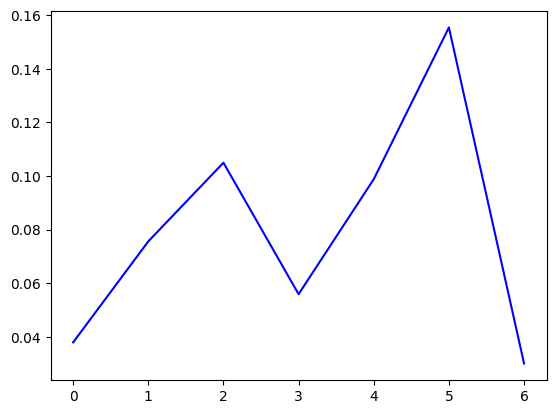

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)),train_losses,color='blue',label='train_loss')
plt.plot(range(len(train_losses)),val_losses,color='red',label='val_loss')
plt.legend()
plt.show()

We can now evaluate the performance of this model.

In [8]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 15.0481
